# **Sports_Classification_Model_Using_Transfer_Learning**

## **1-Import Libraries**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **2-Load Helper Function**

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-29 18:55:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-29 18:55:17 (77.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## **3-Import Function from Helper Function**

In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## **3-Import Split Folder**

In [4]:
pip install split-folders

In [5]:
import splitfolders

## **4-Mount Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**5-Load Data From Google Drive**

In [7]:
import zipfile

# unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Sports_Dataset_model.zip")
zip_ref.extractall()
zip_ref.close()

## **6-Get Class Names Programmatically**

In [8]:
# get the class names prgrammatically
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/Sports_Dataset_model")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # create a list of class_names from the subdirectories
print(class_names)

['air hockey' 'ampute football' 'archery' 'arm wrestling' 'axe throwing'
 'balance beam' 'barell racing' 'baseball' 'basketball' 'baton twirling'
 'bike polo' 'billiards' 'bmx' 'bobsled' 'bowling' 'boxing' 'bull riding'
 'bungee jumping' 'canoe slamon' 'cheerleading' 'chuckwagon racing'
 'cricket' 'croquet' 'curling' 'disc golf' 'fencing' 'field hockey'
 'figure skating men' 'figure skating pairs' 'figure skating women'
 'fly fishing' 'football' 'formula 1 racing' 'frisbee' 'gaga'
 'giant slalom' 'golf' 'hammer throw' 'hang gliding' 'harness racing'
 'high jump' 'hockey' 'horse jumping' 'horse racing' 'horseshoe pitching'
 'hurdles' 'hydroplane racing' 'ice climbing' 'ice yachting' 'jai alai'
 'javelin' 'jousting' 'judo' 'lacrosse' 'log rolling' 'luge'
 'motorcycle racing' 'mushing' 'nascar racing' 'olympic wrestling'
 'parallel bar' 'pole climbing' 'pole dancing' 'pole vault' 'polo'
 'pommel horse' 'rings' 'rock climbing' 'roller derby'
 'rollerblade racing' 'rowing' 'rugby' 'sailboat

## **7-Visualizing The Images**

In [9]:
# let's visualize our image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  # setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # this line means randomly sample one item form the target folder
  print(random_image)

  # read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}") # show thw shape of the image

  return img 

## **8-Split The Images**

In [10]:
splitfolders.ratio("/content/Sports_Dataset_model", output="output",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 14071 files [00:06, 2173.54 files/s]


## **9-Set Train, Test and Validation Paths**

In [75]:
train_dir = '/content/output/train/'
test_dir = '/content/output/test/'
val_dir = '/content/output/val/'

In [12]:
# How many images/classes are there?
walk_through_dir("/content/Sports_Dataset_model")

There are 100 directories and 0 images in '/content/Sports_Dataset_model'.
There are 0 directories and 142 images in '/content/Sports_Dataset_model/hurdles'.
There are 0 directories and 162 images in '/content/Sports_Dataset_model/polo'.
There are 0 directories and 155 images in '/content/Sports_Dataset_model/judo'.
There are 0 directories and 113 images in '/content/Sports_Dataset_model/hydroplane racing'.
There are 0 directories and 162 images in '/content/Sports_Dataset_model/golf'.
There are 0 directories and 196 images in '/content/Sports_Dataset_model/football'.
There are 0 directories and 116 images in '/content/Sports_Dataset_model/mushing'.
There are 0 directories and 143 images in '/content/Sports_Dataset_model/bobsled'.
There are 0 directories and 164 images in '/content/Sports_Dataset_model/figure skating women'.
There are 0 directories and 117 images in '/content/Sports_Dataset_model/ice yachting'.
There are 0 directories and 162 images in '/content/Sports_Dataset_model/sw

## **10-Setup Data Inputs**

In [13]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

Found 11214 files belonging to 100 classes.
Found 1496 files belonging to 100 classes.


## **11-Create Model Checkpoint**

In [14]:
# Create a checkpoint callback
checkpoint_path = "sports_classification_model_using_transfer_learning"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

## **12-Data Augmentation**

In [15]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")


## **13-Set Up Model (Feature Extraction)**

In [16]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [17]:
# Get a summary of model we've been created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 100)               128100    
                                                                 
Total params: 4,177,671
Trainable params: 128,100
Non-trainab

## **14-load and Import Metrics**

In [18]:
from tensorflow.keras import metrics

In [19]:
METRICS = [
  metrics.TruePositives(name="tp"),
  metrics.FalsePositives(name="fp"),
  metrics.TrueNegatives(name="tn"),
  metrics.FalseNegatives(name="fn"),
  metrics.CategoricalAccuracy(name="accuracy"),
  metrics.Precision(name="precision"),
  metrics.Recall(name="recall"),
  metrics.AUC(name="auc")
]

## **15-Compile and Fit The Model**

In [42]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history_feature_extraction = model.fit(train_data,
                                           epochs=5, # fit to 5 epochs to keep experiment quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training 
                                           callbacks=[checkpoint_callback])

Epoch 1/5
351/351 [==============================] - 76s 191ms/step - loss: 0.4791 - tp: 10389.0000 - fp: 1014.0000 - tn: 1257276.0000 - fn: 2321.0000 - accuracy: 0.8603 - precision: 0.9111 - recall: 0.8174 - auc: 0.9956 - val_loss: 0.3869 - val_tp: 190.0000 - val_fp: 21.0000 - val_tn: 22155.0000 - val_fn: 34.0000 - val_accuracy: 0.8571 - val_precision: 0.9005 - val_recall: 0.8482 - val_auc: 0.9949
Epoch 2/5
351/351 [==============================] - 67s 189ms/step - loss: 0.3711 - tp: 9578.0000 - fp: 781.0000 - tn: 1109405.0000 - fn: 1636.0000 - accuracy: 0.8869 - precision: 0.9246 - recall: 0.8541 - auc: 0.9967 - val_loss: 0.4372 - val_tp: 188.0000 - val_fp: 25.0000 - val_tn: 22151.0000 - val_fn: 36.0000 - val_accuracy: 0.8527 - val_precision: 0.8826 - val_recall: 0.8393 - val_auc: 0.9904
Epoch 3/5
351/351 [==============================] - 66s 187ms/step - loss: 0.3180 - tp: 9796.0000 - fp: 726.0000 - tn: 1109460.0000 - fn: 1418.0000 - accuracy: 0.9023 - precision: 0.9310 - recall: 

## **16-Evaluate The Model**

In [45]:
# Evaluate on the whole test dataset  ##its a feature extractin instead of fine tune
history_feature_extraction_results  = model.evaluate(test_data)
history_feature_extraction_results

47/47 [==============================] - 7s 140ms/step - loss: 0.3778 - tp: 1320.0000 - fp: 120.0000 - tn: 147984.0000 - fn: 176.0000 - accuracy: 0.8937 - precision: 0.9167 - recall: 0.8824 - auc: 0.9918


[0.377767950296402,
 1320.0,
 120.0,
 147984.0,
 176.0,
 0.89371657371521,
 0.9166666865348816,
 0.8823529481887817,
 0.9918381571769714]

## **Plot The Graph**

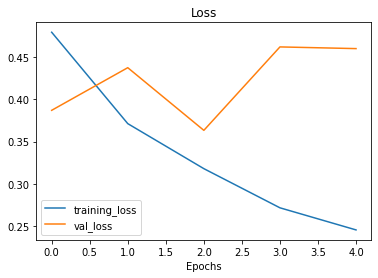

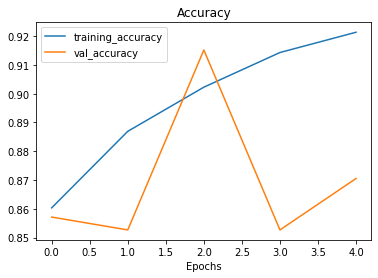

In [46]:
plot_loss_curves(history_feature_extraction)

## **17-Unfreeze Some Layers**

In [47]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

## **18-Recompile The Model**

In [48]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [49]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling_layer True
output_layer True


In [50]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

## **19-Fit The Model**

In [51]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 10 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)))

Epoch 1/10
351/351 [==============================] - 75s 187ms/step - loss: 0.1118 - tp: 12064.0000 - fp: 376.0000 - tn: 1257914.0000 - fn: 646.0000 - accuracy: 0.9600 - precision: 0.9698 - recall: 0.9492 - auc: 0.9986 - val_loss: 0.3710 - val_tp: 198.0000 - val_fp: 21.0000 - val_tn: 22155.0000 - val_fn: 26.0000 - val_accuracy: 0.8839 - val_precision: 0.9041 - val_recall: 0.8839 - val_auc: 0.9951
Epoch 2/10
351/351 [==============================] - 61s 174ms/step - loss: 0.0895 - tp: 10832.0000 - fp: 222.0000 - tn: 1109964.0000 - fn: 382.0000 - accuracy: 0.9728 - precision: 0.9799 - recall: 0.9659 - auc: 0.9997 - val_loss: 0.3504 - val_tp: 199.0000 - val_fp: 21.0000 - val_tn: 22155.0000 - val_fn: 25.0000 - val_accuracy: 0.8884 - val_precision: 0.9045 - val_recall: 0.8884 - val_auc: 0.9973
Epoch 3/10
351/351 [==============================] - 61s 174ms/step - loss: 0.0729 - tp: 10904.0000 - fp: 186.0000 - tn: 1110000.0000 - fn: 310.0000 - accuracy: 0.9772 - precision: 0.9832 - recall:

## **20-Re-Evaluate The Model**

In [52]:
# Evaluate on the whole test dataset
history_fine_tune_results =model.evaluate(test_data)
history_fine_tune_results

47/47 [==============================] - 7s 139ms/step - loss: 0.3122 - tp: 1373.0000 - fp: 95.0000 - tn: 148009.0000 - fn: 123.0000 - accuracy: 0.9251 - precision: 0.9353 - recall: 0.9178 - auc: 0.9924


[0.3122107684612274,
 1373.0,
 95.0,
 148009.0,
 123.0,
 0.9251337051391602,
 0.9352861046791077,
 0.9177807569503784,
 0.9924095869064331]

## **21-Compare The History**

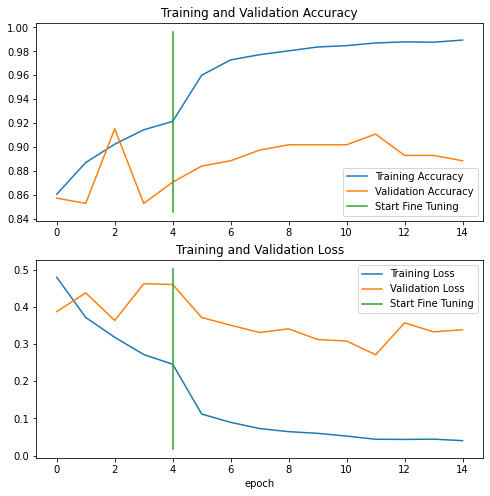

In [53]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history_feature_extraction,
                 new_history=history_fine_tune,
                 initial_epochs=5)

In [57]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it left

47/47 [==============================] - 8s 128ms/step


In [58]:
# Get the pred classes of each model
pred_classes = preds_probs.argmax(axis=1)

# How do they look like?
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## **22-Create Confusion Matrix**

In [64]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

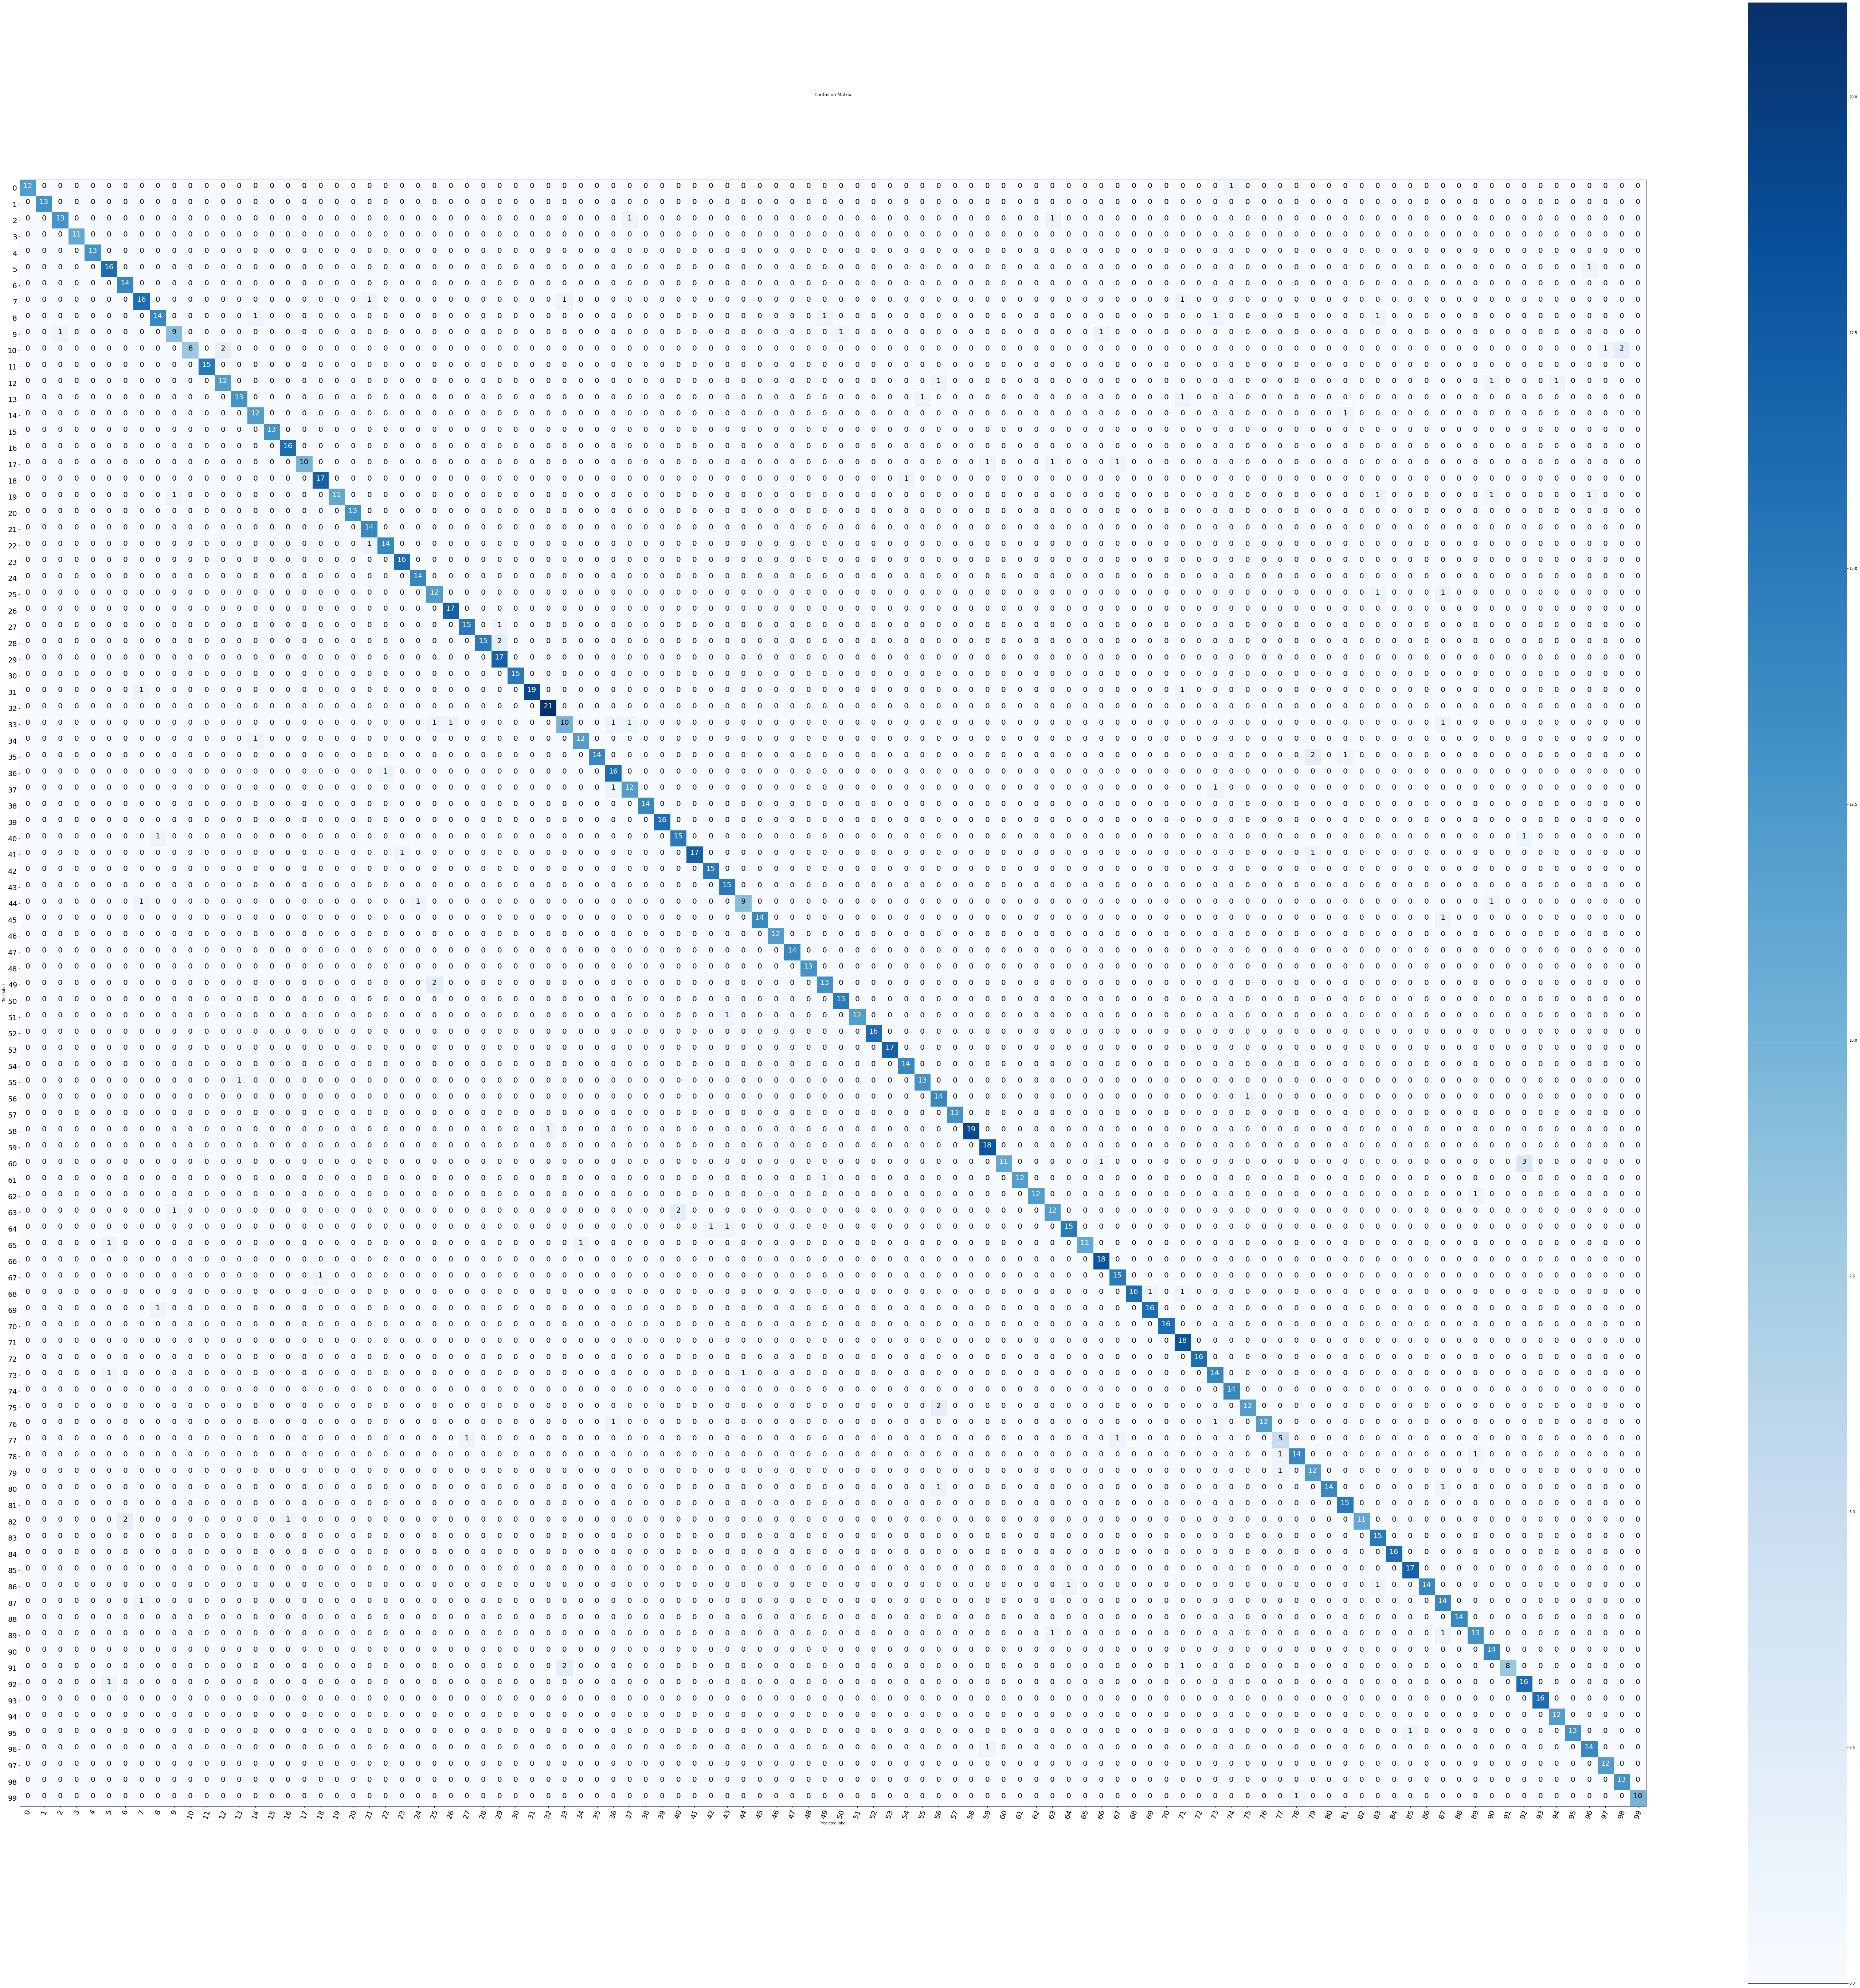

In [65]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
)

## **23-Make Classification Report**

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       1.00      1.00      1.00        13
           2       0.93      0.87      0.90        15
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        13
           5       0.84      0.94      0.89        17
           6       0.88      1.00      0.93        14
           7       0.84      0.84      0.84        19
           8       0.88      0.78      0.82        18
           9       0.82      0.75      0.78        12
          10       1.00      0.62      0.76        13
          11       1.00      1.00      1.00        15
          12       0.86      0.80      0.83        15
          13       0.93      0.87      0.90        15
          14       0.86      0.92      0.89        13
          15       1.00      1.00      1.00        13
          16       0.94      1.00      0.97        16
          17       1.00    

In [69]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.9600000000000001,
  'precision': 1.0,
  'recall': 0.9230769230769231,
  'support': 13},
 '1': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 13},
 '10': {'f1-score': 0.761904761904762,
  'precision': 1.0,
  'recall': 0.6153846153846154,
  'support': 13},
 '11': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 15},
 '12': {'f1-score': 0.8275862068965518,
  'precision': 0.8571428571428571,
  'recall': 0.8,
  'support': 15},
 '13': {'f1-score': 0.896551724137931,
  'precision': 0.9285714285714286,
  'recall': 0.8666666666666667,
  'support': 15},
 '14': {'f1-score': 0.888888888888889,
  'precision': 0.8571428571428571,
  'recall': 0.9230769230769231,
  'support': 13},
 '15': {'f1-score': 1.0, 'precision': 1.0, 'recall': 1.0, 'support': 13},
 '16': {'f1-score': 0.9696969696969697,
  'precision': 0.9411764705882353,
  'recall': 1.0,
  'support': 16},
 '17': {'f1-score': 0.8695652173913044,
  'precision': 1.0,
  'recall': 0.7692307692307693,
 

In [70]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


{'air hockey': 0.9600000000000001,
 'ampute football': 1.0,
 'archery': 0.896551724137931,
 'arm wrestling': 1.0,
 'axe throwing': 1.0,
 'balance beam': 0.8888888888888888,
 'barell racing': 0.9333333333333333,
 'baseball': 0.8421052631578947,
 'basketball': 0.823529411764706,
 'baton twirling': 0.7826086956521738,
 'bike polo': 0.761904761904762,
 'billiards': 1.0,
 'bmx': 0.8275862068965518,
 'bobsled': 0.896551724137931,
 'bowling': 0.888888888888889,
 'boxing': 1.0,
 'bull riding': 0.9696969696969697,
 'bungee jumping': 0.8695652173913044,
 'canoe slamon': 0.9444444444444444,
 'cheerleading': 0.846153846153846,
 'chuckwagon racing': 1.0,
 'cricket': 0.9333333333333333,
 'croquet': 0.9333333333333333,
 'curling': 0.9696969696969697,
 'disc golf': 0.9655172413793104,
 'fencing': 0.8275862068965518,
 'field hockey': 0.9714285714285714,
 'figure skating men': 0.9375,
 'figure skating pairs': 0.9375,
 'figure skating women': 0.9189189189189189,
 'fly fishing': 1.0,
 'football': 0.950000

In [71]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores                

,class_names,f1-score
39,harness racing,1.000000
11,billiards,1.000000
38,hang gliding,1.000000
53,lacrosse,1.000000
52,judo,1.000000
...,...,...
63,pole vault,0.800000
9,baton twirling,0.782609
10,bike polo,0.761905
77,sky surfing,0.714286


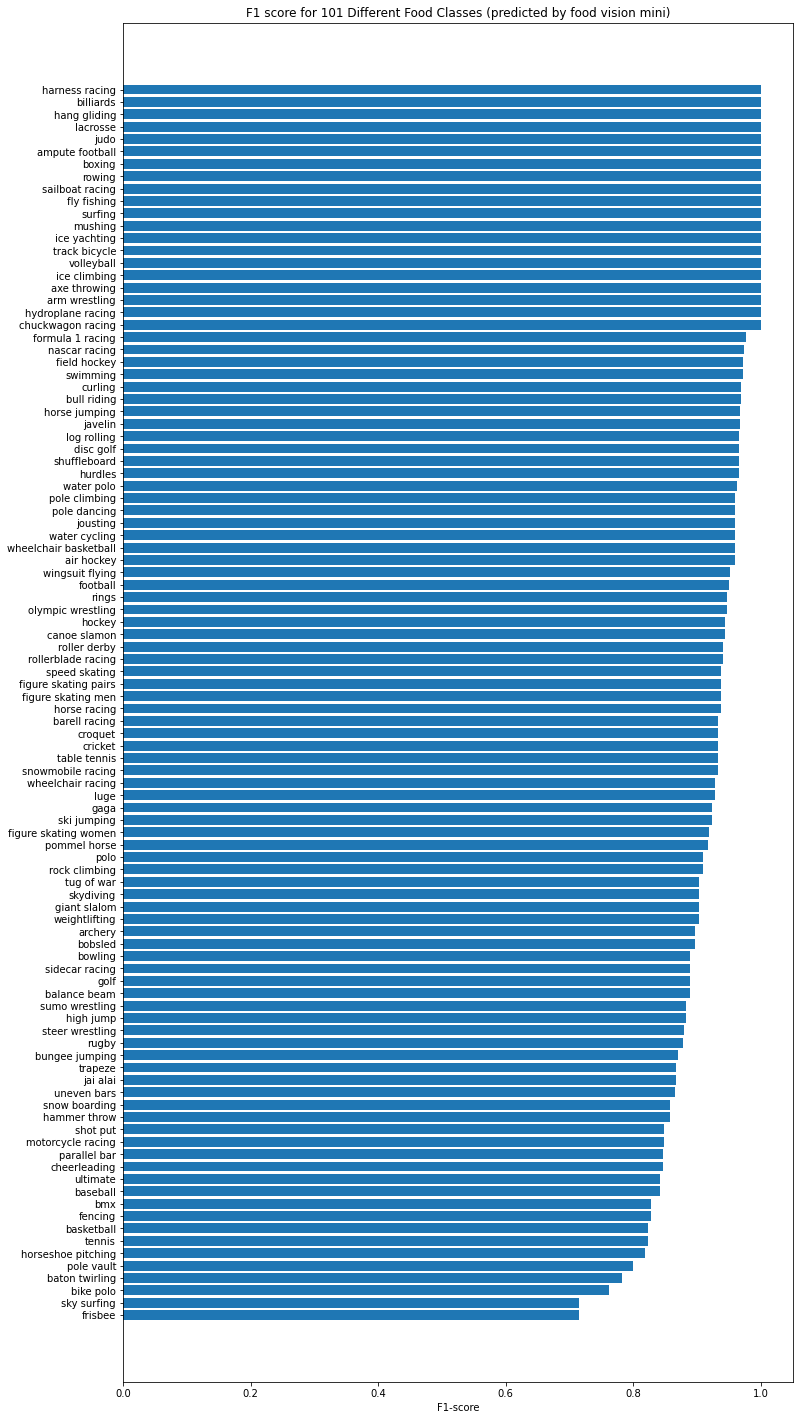

In [72]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot


# Challenge: add value to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) 

## **24-Load And Create Images Function**

In [73]:
# Create a function to load and create a images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Read in an image from filename, turn it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename(str): path to target image
    image_shape(int): height/width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    image tensor of shape (img_shape, img_shape, 3)
  """

  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3) 

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale Yes/no?
  if scale:
    # reshape the image (get all value between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale image for EffiecienNet model in TensorFlow   


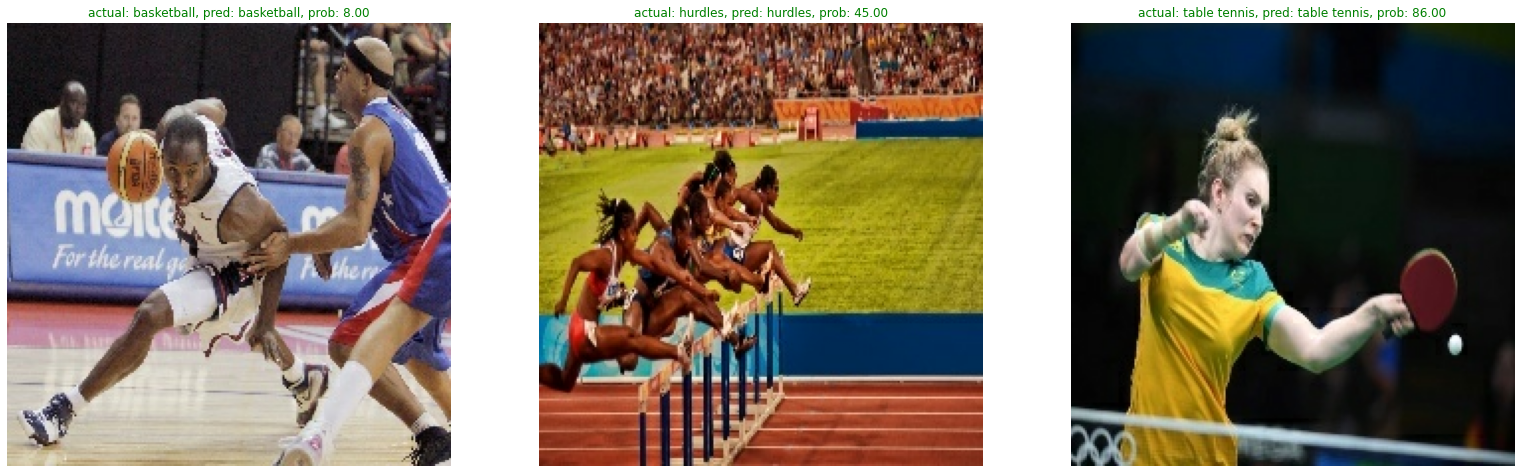

In [76]:
# Make preds on series of images
import os
import random

plt.figure(figsize=(27,10))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name =random.choice(class_names)
  filename = random.choice(os.listdir(val_dir + "/" + class_name))
  filepath = val_dir + class_name + "/" + filename


  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  # print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  # print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probability array
  pred_class = class_names[pred_prob.argmax()] # get heighst prediction probability index and match it class_names list
  # print(pred_prob)
   # print(pred_class)

    # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color ="r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.argmax():.2f}", c=title_color)
  plt.axis(False);  

## **25-Custom Images**

In [95]:
img = '/content/baseball.jpg'

(-0.5, 223.5, 223.5, -0.5)

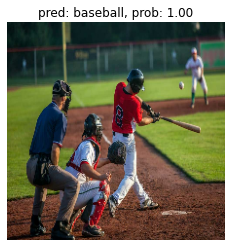

In [96]:
# Make prediction on and plot the custom food images
img = load_and_prep_image(img, scale=False) # don't need to do scale for our EfficienNetB0 model
pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on the image with shape [1, 224,224, 1] (same shape as model trained on)
pred_class = class_names[pred_prob.argmax()] # get the index with heighest prediction probability
# plot the appropriate information
plt.figure()
plt.imshow(img/255.)
plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
plt.axis(False)